In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data Handling
import os
import re
import string
import numpy as np
import pandas as pd
from numpy import array
from numpy import asarray
from numpy import zeros

# NLP Preprocessing
# import nltk
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Machine Learning & Model Evaluation
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    confusion_matrix, accuracy_score
)
# from skmultilearn.adapt import MLkNN

# Deep Learning (Keras & TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/ta_transfer.csv')


In [4]:
# Word Pre-Processing

def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text




In [5]:
d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1

,text,label
0,அருமை படைப்புகள் நன்றி சகோ,Non-Hate-Speech
1,உனக்கு gay புள்ள பொறந்தா என்னடா பண்ணுவ ...,Non-Hate-Speech
2,nishanthini krishnamoorthy மன்னிப்பு தமிழ்ல ...,Non-Hate-Speech
3,செமையா சகோ,Non-Hate-Speech
4,இறைவனின் மறுபிறவி மனித மிருகங்களால் எந்த தொல்ல...,Non-Hate-Speech
...,...,...
5498,முட்டல் அவன் சொல்ல வந்தது வெற நீங்கள் புரிந்து...,Non-Hate-Speech
5499,அது யாழின் பாரம்பரிய உணவான புட்டை பெருமை படுத்...,Non-Hate-Speech
5500,அவர் தன்னுடைய கருத்தை கவிதை மூலமும் பாடல் மூலம...,Non-Hate-Speech
5501,யதார்த்தமான கருத்தை புரியமுடியாவிட்டால் அதை கட...,Non-Hate-Speech


In [7]:
# Re-map the labels: 0 and 1 → 1, 2 → 0
d1['label'] = d1['label'].apply(lambda x: 1 if x in ["Hate-Speech"] else 0)

# Now keep only 7000 samples of the new label=1
label1_df = d1[d1['label'] == 1]

# Combine with all label=0 data
label0_df = d1[d1['label'] == 0]

# Concatenate the two subsets
d1_balanced = pd.concat([label1_df, label0_df]).reset_index(drop=True)


In [12]:
# Show value counts of the labels
print(d1_balanced['label'].value_counts())

# Keep only 'tweet' and 'label' columns, rename 'tweet' to 'text'
# d1_balanced = d1_balanced[['tweet', 'class']].rename(columns={'tweet': 'text', 'class': 'label'})

d1_balanced


label
0    3573
1    1930
Name: count, dtype: int64


,text,label
0,நீ மொத ஆம்பலயா பொம்பலயா அத சொல்லு மூதேவி,1
1,மனித இனம் விரைவில் அழியும்னு சொன்னாங்க அப்ப ...,1
2,பப்ளிக்ள போனா உங்கள் மாறி ஆளுங்க violence கெளப...,1
3,இது ஒரு மன நோயாளி நீ சொன்ன எல்லாத்துக்கும் தண்...,1
4,உலக முடிவு என்பது நீதிபதியிடம் இருந்து ...,1
...,...,...
5498,முட்டல் அவன் சொல்ல வந்தது வெற நீங்கள் புரிந்து...,0
5499,அது யாழின் பாரம்பரிய உணவான புட்டை பெருமை படுத்...,0
5500,அவர் தன்னுடைய கருத்தை கவிதை மூலமும் பாடல் மூலம...,0
5501,யதார்த்தமான கருத்தை புரியமுடியாவிட்டால் அதை கட...,0


In [13]:
# Display the head to verify
d1_balanced.head()
d1=d1_balanced

In [14]:
X1 = list(d1['text'])
y_data1 = d1["label"]

y1 = y_data1.values

print(y1)
print(len(y1))


[1 1 1 ... 0 0 0]
5503


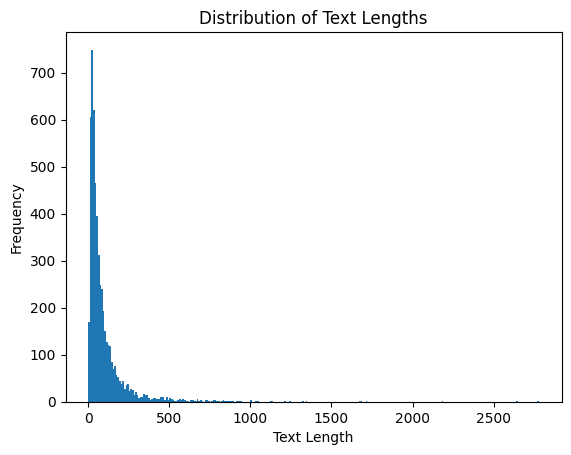

Average Text Length: 97.2771215700527


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate the lengths of each text element
text_lengths = d1['text'].str.len()

# Create a histogram with bins of size 10
plt.hist(text_lengths, bins=range(0, text_lengths.max() + 10, 10))

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# Calculate and print the average text length
average_length = text_lengths.mean()
print(f"Average Text Length: {average_length}")

# Get counts for each bucket of 10
bins = range(0, text_lengths.max() + 10, 10)
counts, _ = np.histogram(text_lengths, bins=bins)

sum=0
# Print the counts for each bucket
for i in range(len(bins) - 1):
    sum+=counts[i]
    # print(f"Length {bins[i]}-{bins[i+1]}: {counts[i]} {sum}")

In [35]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU, MultiHeadAttention
from tensorflow.keras.models import Model
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.regularizers import l2
# ======================
# CONFIGURATION
# ======================
MAX_LEN = 128  # Reduced for English text
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-7
VAL_SPLIT = 0.2
# CLASS_WEIGHT = {0: 1, 1: 2}  # Adjusted for English class distribution
XLM_MODEL_NAME = 'xlm-roberta-base'


def compute_class_weights(labels):
 numbered_classes = np.unique(labels)
 from sklearn.utils.class_weight import compute_class_weight
 weights = compute_class_weight('balanced', classes=numbered_classes, y=labels)
 return dict(zip(numbered_classes, weights))

# ======================
# MODEL ARCHITECTURE
# ======================
class XLMRobertaEmbedding(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.xlm_model = TFXLMRobertaModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.xlm_model(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True
        ).last_hidden_state

def create_model():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

    # XLM-R Embeddings
    embeddings = XLMRobertaEmbedding(XLM_MODEL_NAME)([input_ids, attention_mask])

    # BiGRU with reduced units for English
    gru_out = Bidirectional(GRU(256, return_sequences=True))(embeddings)

    # Multi-Head Attention
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)

    # Pooling + Classification
    pooled = tf.keras.layers.GlobalAveragePooling1D()(attention)
    dropout = Dropout(0.5)(pooled)  # Increased dropout
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(dropout)

    return Model(inputs=[input_ids, attention_mask], outputs=output)


In [36]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [37]:
# ======================
# DATA PREPARATION
# ======================
# def load_english_data(file_path):
#     df = pd.read_csv(file_path)
#     df['text'] = df['text'].apply(lambda x: x.lower())  # Basic English preprocessing
#     return df

# Load dataset (replace with your English data path)
english_df = d1

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    english_df['text'].values,
    english_df['label'].values,
    test_size=VAL_SPLIT,
    stratify=english_df['label'],
    random_state=42
)

# Compute class weights
CLASS_WEIGHT = compute_class_weights(y_train)
# Tokenization
tokenizer = XLMRobertaTokenizer.from_pretrained(XLM_MODEL_NAME)

def preprocess(texts):
    return tokenizer(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_enc = preprocess(X_train)
val_enc = preprocess(X_val)

# ======================
# MODEL TRAINING
# ======================
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    {'input_ids': train_enc['input_ids'], 'attention_mask': train_enc['attention_mask']},
    y_train,
    validation_data=(
        {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
        y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHT
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 69s 397ms/step - accuracy: 0.4853 - loss: 0.7181 - val_accuracy: 0.3806 - val_loss: 0.7141
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 50s 365ms/step - accuracy: 0.4877 - loss: 0.7088 - val_accuracy: 0.3797 - val_loss: 0.7139
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.4934 - loss: 0.7179 - val_accuracy: 0.3842 - val_loss: 0.7140
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 50s 364ms/step - accuracy: 0.4798 - loss: 0.7121 - val_accuracy: 0.3887 - val_loss: 0.7137
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 83s 369ms/step - accuracy: 0.5011 - loss: 0.7098 - val_accuracy: 0.3969 - val_loss: 0.7136


In [38]:

# ======================
# EVALUATION & VISUALIZATION
# ======================
def evaluate_model(model, data, true_labels):
    y_pred = model.predict(data)
    y_pred_labels = (y_pred > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(true_labels, y_pred_labels))
    print(f"F1 Score: {f1_score(true_labels, y_pred_labels, average='weighted'):.4f}")

print("English Validation Results:")
evaluate_model(model,
    {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
    y_val
)


English Validation Results:
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.17      0.27       715
           1       0.35      0.81      0.48       386

    accuracy                           0.40      1101
   macro avg       0.49      0.49      0.38      1101
weighted avg       0.53      0.40      0.35      1101

F1 Score: 0.3475


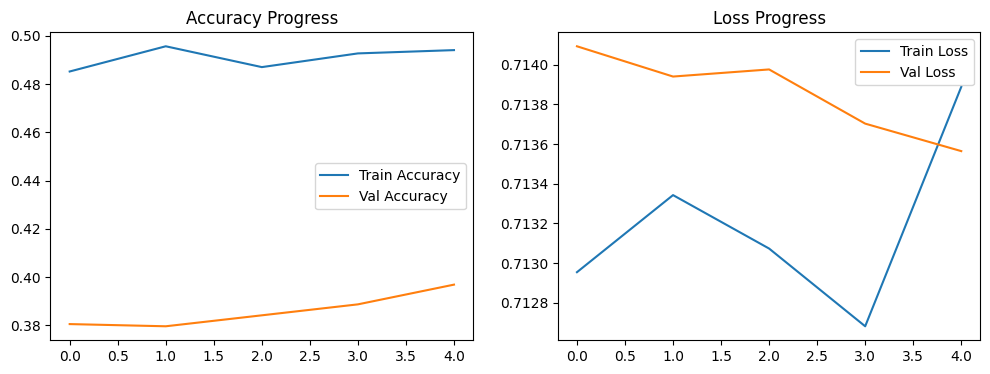

In [40]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.legend()
plt.show()

In [42]:
# Save model (TensorFlow SavedModel format)
model.save("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_Model.keras")

# Save tokenizer

from transformers import XLMRobertaTokenizer

# Save tokenizer in a dedicated directory
tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer")

('/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer/sentencepiece.bpe.model',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer/added_tokens.json')

# Fine tuning

In [43]:
# ======================
# LOAD SAVED MODEL
# ======================
print("Loading the saved model...")
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_Model.keras",
    custom_objects={'XLMRobertaEmbedding': XLMRobertaEmbedding}
)

Loading the saved model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [44]:
# ======================
# FREEZE LAYERS FOR FINETUNING
# ======================
print("Freezing the base layers...")

# Print model summary to see layer names and structure
print("Model layers:")
for i, layer in enumerate(loaded_model.layers):
    print(f"{i}: {layer.name}")

Freezing the base layers...
Model layers:
0: input_ids
1: attention_mask
2: xlm_roberta_embedding_6
3: bidirectional_6
4: multi_head_attention_6
5: global_average_pooling1d_6
6: dropout_13
7: dense_5


In [45]:
# Freeze XLM-RoBERTa embedding layer
for layer in loaded_model.layers:
    if isinstance(layer, XLMRobertaEmbedding):
        print(f"Freezing layer: {layer.name}")
        layer.trainable = False

Freezing layer: xlm_roberta_embedding_6


In [46]:
'''
for layer in loaded_model.layers:
    if "gru" in layer.name.lower() or "bidirectional" in layer.name.lower():
        print(f"Freezing layer: {layer.name}")
        layer.trainable = False
'''

'\nfor layer in loaded_model.layers:\n    if "gru" in layer.name.lower() or "bidirectional" in layer.name.lower():\n        print(f"Freezing layer: {layer.name}")\n        layer.trainable = False\n'

In [47]:
new_train_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')

# Preprocess the new training data
print("Preprocessing training data...")
def normalize_text(text):
    emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
    text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('<handle replaced>', '', text)
    text = emoji_pattern.sub(r'', text)
    return text

Preprocessing training data...


In [49]:
new_train_df['text'] = new_train_df['text'].apply(lambda x: normalize_text(x))

# Extract labels from annotation columns
col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    new_train_df[col] = pd.to_numeric(new_train_df[col], errors='coerce')

# Use maximum annotation value as the label
new_train_df['label'] = new_train_df[col_lst].max(axis=1, skipna=True).astype(int)
new_train_df = new_train_df[['text', 'label']]

# Check class distribution
print("Class distribution in new training data:")
print(new_train_df['label'].value_counts())

Class distribution in new training data:
label
0    3777
1    3002
Name: count, dtype: int64


In [50]:
# Split new training data
X_finetune, X_val, y_finetune, y_val = train_test_split(
    new_train_df['text'].values,
    new_train_df['label'].values,
    test_size=0.2,
    stratify=new_train_df['label'],
    random_state=42
)

In [51]:
tokenizer = XLMRobertaTokenizer.from_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer")

# Tokenize the new training data
def preprocess(texts):
    return tokenizer(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

finetune_enc = preprocess(X_finetune)
finetune_val_enc = preprocess(X_val)

In [55]:

# Compile with a lower learning rate for finetuning
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-7),  # Even lower learning rate for partial finetuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Calculate class weights if imbalanced
unique, counts = np.unique(y_finetune, return_counts=True)
class_weights = {i: len(y_finetune) / (len(unique) * count) for i, count in zip(unique, counts)}
print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.8975504799735187), np.int64(1): np.float64(1.1288509575353871)}


In [56]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [57]:
# Finetune the model
finetune_history = loaded_model.fit(
    {'input_ids': finetune_enc['input_ids'], 'attention_mask': finetune_enc['attention_mask']},
    y_finetune,
    validation_data=(
        {'input_ids': finetune_val_enc['input_ids'], 'attention_mask': finetune_val_enc['attention_mask']},
        y_val
    ),
    epochs=5,  # Potentially more epochs but with early stopping
    batch_size=16,  # Smaller batch size for finetuning
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/5
339/339 ━━━━━━━━━━━━━━━━━━━━ 85s 209ms/step - accuracy: 0.5341 - loss: 0.7123 - val_accuracy: 0.5730 - val_loss: 0.7105
Epoch 2/5
339/339 ━━━━━━━━━━━━━━━━━━━━ 87s 223ms/step - accuracy: 0.5227 - loss: 0.7109 - val_accuracy: 0.5553 - val_loss: 0.7109
Epoch 3/5
339/339 ━━━━━━━━━━━━━━━━━━━━ 82s 223ms/step - accuracy: 0.5083 - loss: 0.7123 - val_accuracy: 0.5568 - val_loss: 0.7110


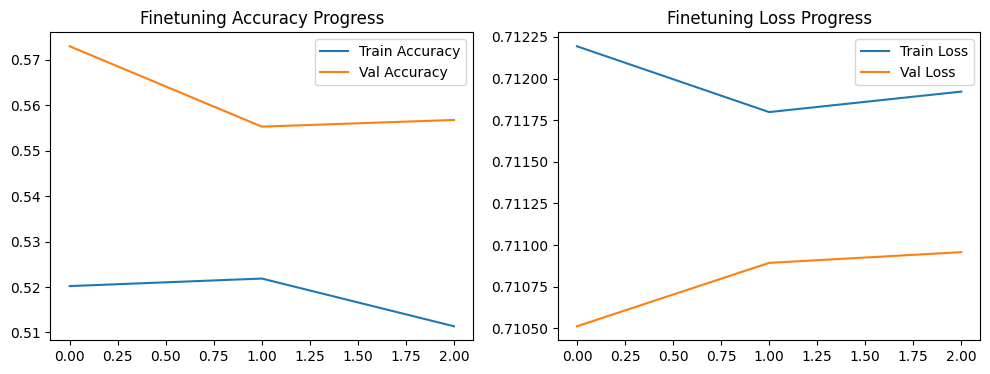

In [58]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(finetune_history.history['accuracy'], label='Train Accuracy')
plt.plot(finetune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Finetuning Accuracy Progress')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(finetune_history.history['loss'], label='Train Loss')
plt.plot(finetune_history.history['val_loss'], label='Val Loss')
plt.title('Finetuning Loss Progress')
plt.legend()
plt.show()

In [59]:
# Evaluate on validation set
print("Evaluating finetuned model on validation set:")
val_predictions = loaded_model.predict({
    'input_ids': finetune_val_enc['input_ids'],
    'attention_mask': finetune_val_enc['attention_mask']
})
val_binary_preds = (val_predictions > 0.5).astype(int).flatten()
print(classification_report(y_val, val_binary_preds))

Evaluating finetuned model on validation set:
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 553ms/step
              precision    recall  f1-score   support

           0       0.58      0.83      0.68       756
           1       0.54      0.25      0.34       600

    accuracy                           0.57      1356
   macro avg       0.56      0.54      0.51      1356
weighted avg       0.56      0.57      0.53      1356



In [60]:
# Save the finetuned model
loaded_model.save("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_Model_Finetuned.keras")
print("Finetuned model saved!")


Finetuned model saved!


# Transfer Learning: Testing


In [61]:
import tensorflow as tf
from transformers import XLMRobertaTokenizer

# Load model with custom layer handling
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_Model_Finetuned.keras",
    custom_objects={'XLMRobertaEmbedding': XLMRobertaEmbedding}
)

# Load tokenizer
tokenizer1 = XLMRobertaTokenizer.from_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Tamil/task2/Task2_tokenizer")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [62]:
vv_1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')
vv1=vv_1


In [63]:
vv_1['text'] = vv_1['text'].apply(lambda x: normalize_text(x))

# vv['text'] = vv['text'].apply(lambda x: normalize_text_2(x))
vv_1 = vv_1[['text']]

vv_1.columns = ['text']
vv_1

,text
0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...
1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...
2,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...
3,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...
4,bachelor படமாடா இது கோத்தா
...,...
1130,ஊம்பு
1131,தமிழ் தெரிஞ்சவன் தான் உங்கொம்மால குண்டி அடிக்...
1132,நீ தான் பங் அவனோலுக்கு கரெக்டா ஆன ஆளு லத்த...
1133,— ஆமாம் வேச ஆமாம் வேச அய்ம் ச்லீபின் அய்ம் ச்...


In [64]:
# X = list(vv1['text'])
#y = np.asarray(d1[d1.columns[1:]])
col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    vv1[col] = pd.to_numeric(vv1[col], errors='coerce')



vv1['label'] = vv1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values


vv1['label'] = vv1['label'].astype(int)


vv1 = vv1[['label', 'text']]


true_1 = vv1["label"]

# print(true_)
y_test_1 = true_1.values

print(y_test_1)
print(len(y_test_1))

[0 1 0 ... 1 1 1]
1135


In [65]:
X_test=vv1['text'].values
y_test=vv1['label'].values

In [66]:
# sequence1 = tokenizer1.texts_to_sequences(vv_1['text']) # same tokenizer which is used on train data.

def preprocess(texts):
    return tokenizer1(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

In [67]:
test_enc = preprocess(X_test)


Test Set Evaluation:
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step

Best Threshold: 0.4903
              precision    recall  f1-score   support

     Neutral       0.73      0.06      0.11       414
       Abuse       0.65      0.99      0.78       721

    accuracy                           0.65      1135
   macro avg       0.69      0.52      0.44      1135
weighted avg       0.68      0.65      0.54      1135

Weighted F1: 0.5354


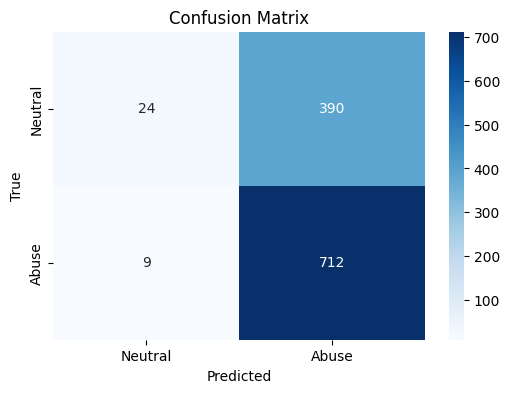

In [68]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve

# ======================
# PREDICTION & EVALUATION
# ======================
def evaluate_model(model, data, true_labels):
    # Get predictions
    y_pred_probs = model.predict({
        'input_ids': data['input_ids'],
        'attention_mask': data['attention_mask']
    })

    # Find optimal threshold
    precision, recall, thresholds = precision_recall_curve(true_labels, y_pred_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Apply threshold
    y_pred = (y_pred_probs > best_threshold).astype(int)

    # Metrics
    print(f"\nBest Threshold: {best_threshold:.4f}")
    print(classification_report(true_labels, y_pred, target_names=['Neutral', 'Abuse']))
    print(f"Weighted F1: {f1_score(true_labels, y_pred, average='weighted'):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Neutral', 'Abuse'],
                yticklabels=['Neutral', 'Abuse'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

print("Test Set Evaluation:")
evaluate_model(loaded_model, test_enc, y_test)



In [69]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve



# ======================
# SAMPLE PREDICTIONS
# ======================
def show_predictions(texts, labels, num_samples=5):
    indices = np.random.choice(len(texts), num_samples, replace=False)
    for idx in indices:
        text = texts[idx]
        true_label = labels[idx]

        inputs = tokenizer1(
            text,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )
        pred_prob = loaded_model.predict([inputs['input_ids'], inputs['attention_mask']])[0][0]
        pred_label = "Abuse" if pred_prob > 0.5 else "Neutral"

        print(f"\nText: {text[:100]}...")
        print(f"True: {true_label} | Predicted: {pred_label} ({pred_prob:.4f})")

print("\nSample Predictions:")
show_predictions(X_test, y_test)


Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Text:  எனக்கு தெரிஞ்சி ஓரு குரூப் கிட்ட தான் பொண்ண காப்பாத்தணும் அது யாருனு தெரியும் நீ கிளம்பு   சென்னை ல...
True: 1 | Predicted: Neutral (0.4967)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Text:  நவ திருப்பதி    ஒன்பது வைணவ தலங்கள்...
True: 0 | Predicted: Neutral (0.4989)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Text: தெலுங்கன்ஸ் ஊம்பு ஊம்புன்னு ஊம்புறானுங்க   tl ஒரே கலவரம இருக்கு    master...
True: 1 | Predicted: Neutral (0.4990)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

Text:     அப்போ இந்த புண்டை அடிச்சி கிழி ப்ரோ ...
True: 1 | Predicted: Abuse (0.5018)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

Text: பேசாம கமல் ரசிகனா மாறிடலாம் போல எவன் கமல அசிங்க அசிங்கமா கேவலமா பச்சை பச்சையா கோத்தா கொம்மானு திட்டு...
True: 1 | Predicted: Neutral (0.4919)
